In [8]:
import h5py
import numpy as np
import torch.nn.functional as F
import torch
import pandas as pd
import scipy

In [ ]:
PATH_SAVED_ATT = "/Users/sonerkoc/Downloads/2954_blockmap.h5"
WSI_ID = "2954"

In [ ]:
file_h5 = h5py.File(PATH_SAVED_ATT, 'r')
print(f"List of data groups in the h5: {list(file_h5.keys())}")

## Values used in Heatmap

In [ ]:
# Access H5 Data Groups
aset = file_h5['attention_scores']
cset = file_h5['coords']

# Raw Attention
attention = np.array(aset)[:,0]

# Rank Attention scores
from scipy.stats import rankdata
scores_percentile = rankdata(attention, 'average')/len(attention)

# Softmax Attention scores - Used in Evaluation, not in Heatmap
tensor_att = torch.from_numpy(np.array(aset))
tensor_att = torch.transpose(tensor_att, 1, 0)
scores_numpy_for_eval = F.softmax(tensor_att, dim=1).numpy()

# Create Data
data = {'x': np.array(cset)[:,0], 
        'y': np.array(cset)[:,1],
        'attention_score': attention, 
        'attention_ranked': scores_percentile,
        'attention_eval':scores_numpy_for_eval.T[:,0]}

# Pandas DataFrame
df_att = pd.DataFrame(data=data)
print(f"Shape of the Attention Table: {df_att.shape}")
df_att.head()

In [ ]:
df_att.to_csv(f"{WSI_ID}-attention-table.csv", index=False)

# View

In [1]:
import openslide

In [17]:
WSI_ID = "2954"
df_region = pd.read_csv(f"{WSI_ID}-attention-table.csv")
df_region = df_region.sort_values(by=['attention_ranked'], ascending=False).reset_index(drop=True)



In [18]:
df_region.head()

,x,y,attention_score,attention_ranked,attention_eval
0,130368,61184,-5.975676,1.000000,0.021916
1,122176,51968,-6.092378,0.999798,0.019502
2,127296,40704,-6.092427,0.999596,0.019501
3,46464,44544,-6.161992,0.999395,0.018190
4,133440,50944,-6.329283,0.999193,0.015388


## View High-Low Ranked Image Pathes

In [2]:
wsi = openslide.open_slide("/Users/sonerkoc/Downloads/2954.tiff")

In [61]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

# Get image with coords
get_image = lambda index : wsi.read_region((int(df_region.iloc[index,:].x), int(df_region.iloc[index,:].y)), 0, (1024, 1024))

def plot_grid(high_low, index=[1,10,100,1000]):
    
    im1 = get_image(index[0] if high_low=='high' else -index[0])
    im2 = get_image(index[1] if high_low=='high' else -index[1])
    im3 = get_image(index[2] if high_low=='high' else -index[2])
    im4 = get_image(index[3] if high_low=='high' else -index[3])
    
    fig = plt.figure(figsize=(10., 10.))
    grid = ImageGrid(fig, 111,  
                     nrows_ncols=(2, 2),  
                     axes_pad=0.1, 
                     )

    for ax, im in zip(grid, [im1, im2, im3, im4]):
        ax.imshow(im)
    plt.show()

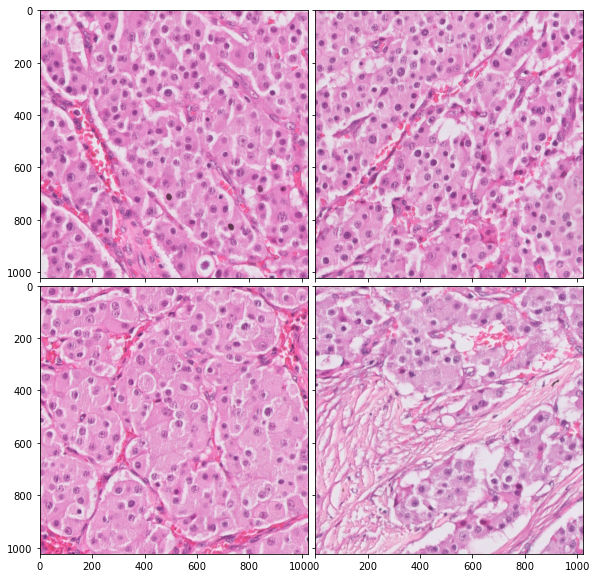

In [62]:
%matplotlib inline
plot_grid("high")

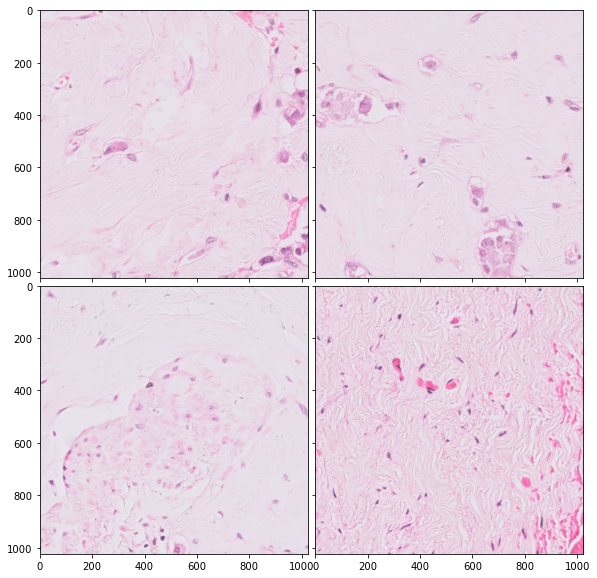

In [63]:
%matplotlib inline
plot_grid("low")